In [1]:
import torch
import torch.nn as nn
import os
import sys

sys.path.append('../')

import numpy as np
import math
import scipy.special as bessel
from scipy.io import loadmat
import pickle
import importlib
import DRLPDE.neuralnets as neuralnets
#import DRLPDE.plotting as tools

import matplotlib.pyplot as plt
import cv2

import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.size'] = 12

In [2]:
loadmodel = 'Thesisexample1'


In [3]:
with open('../experiments/' + loadmodel + '_parameters.pickle', 'rb') as f:
    parameters = pickle.load(f)

param = importlib.import_module(".Thesisexample1", package='examples')

input_dim = [param.x_dim, param.t_dim, param.hyper_dim]
output_dim = param.output_dim

if parameters['neuralnetwork'] == 'FeedForward':
    MyNeuralNetwork = neuralnets.FeedForwardNN
elif parameters['neuralnetwork'] == 'Incompressible':
    MyNeuralNetwork = neuralnets.IncompressibleNN
elif parameters['neuralnetwork'] == 'ResNet':
    MyNeuralNetwork = neuralnets.ResNetNN
elif parameters['neuralnetwork'] == 'ResNetIncompressible':
    MyNeuralNetwork = neuralnets.ResNetIncompressible

nn_size = parameters['nn_size']

model = MyNeuralNetwork(input_dim, output_dim, **nn_size)
model.load_state_dict(torch.load("../savedmodels/" + loadmodel + ".pt"))

<All keys matched successfully>

In [4]:
[ [xmin, xmax], [ymin, ymax]] =  param.boundingbox

num_x = 256
num_y = 64

X = torch.cartesian_prod( torch.linspace(xmin, xmax, num_x), torch.linspace(ymin, ymax, num_y)).requires_grad_()


In [5]:
Velocity = model(X)

flow_max = 5.0

flow_levels = np.linspace(0.0, flow_max, 21)
flow_ticks = np.linspace(0.0, flow_max, 3)


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


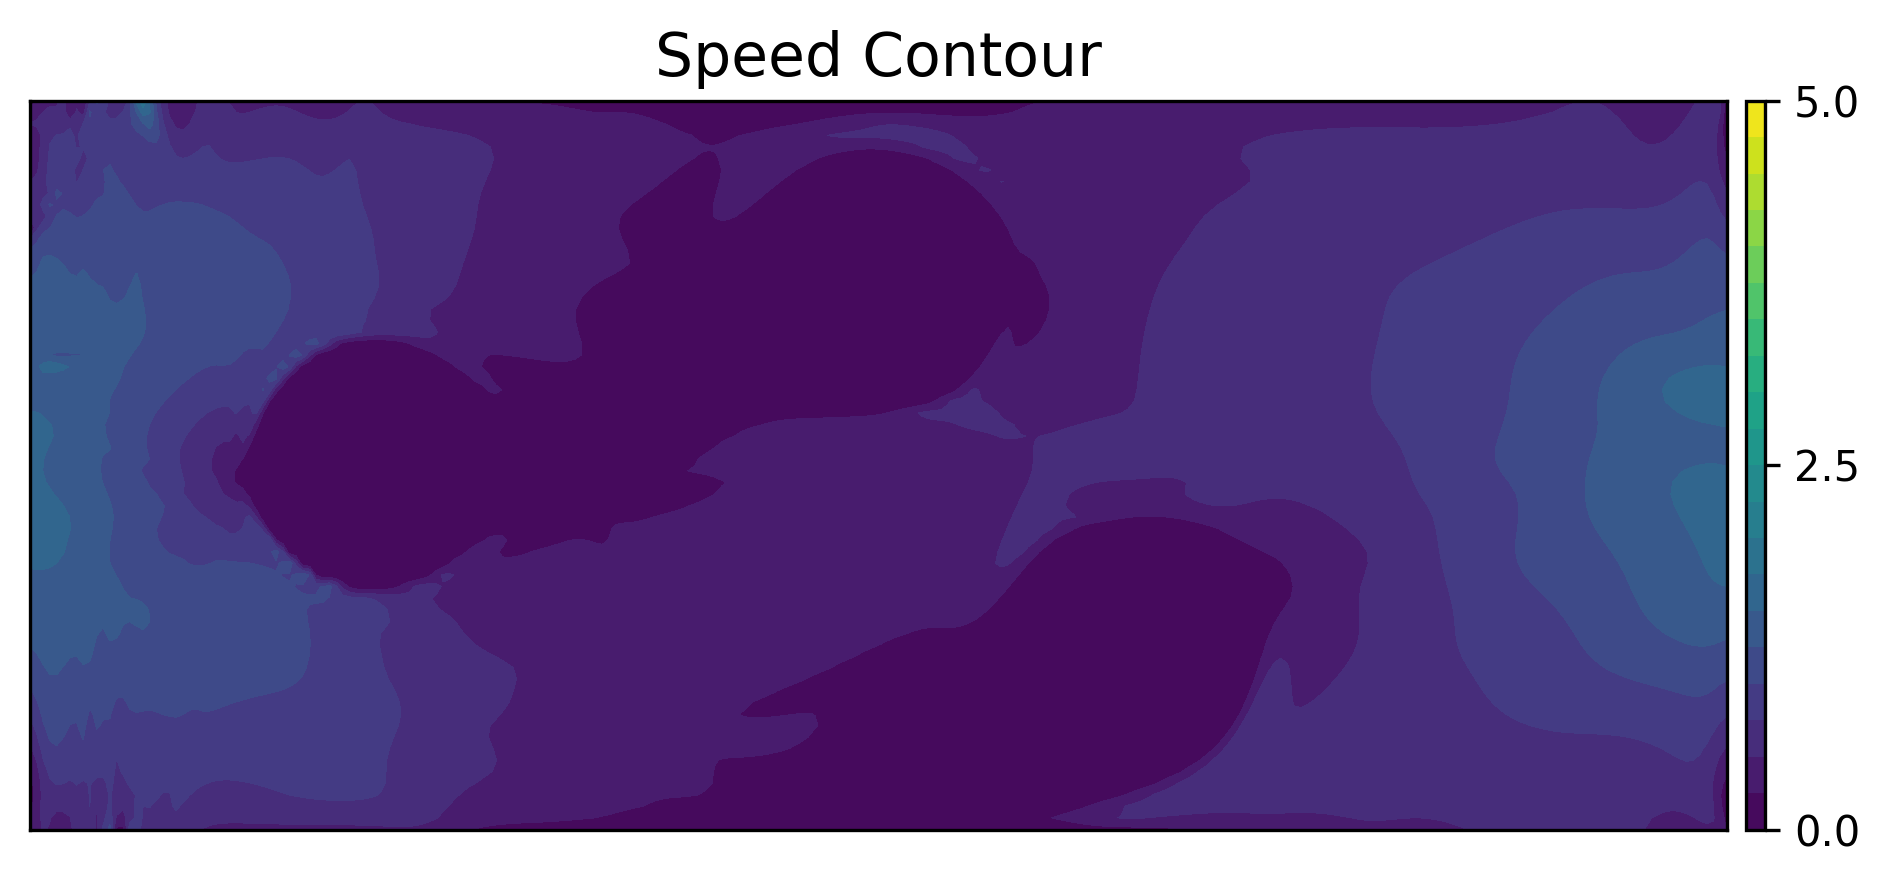

In [6]:
### Plotting

plt.close('all')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6.4, 3.0])
plt.tight_layout(pad=0.75)

## Plot 0

contour0 = ax.contourf(X[:,0].reshape(num_x, num_y).detach().numpy(),
                       X[:,1].reshape(num_x, num_y).detach().numpy(),
                       torch.sqrt(Velocity[:,0]**2 + Velocity[:,1]**2).reshape(num_x, num_y).detach().numpy(),
                       flow_levels, cmap=plt.cm.viridis)

ax.set_title('Speed Contour')

ax.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False
)

colorbar0_param = fig.add_axes(
    [ax.get_position().x1 + 0.01,
     ax.get_position().y0,
     0.01,
     ax.get_position().height])
colorbar0 = plt.colorbar(contour0, ticks=flow_ticks, cax = colorbar0_param)
colorbar0.ax.tick_params(labelsize=10)

